In [1]:
#import necessary packages
import pandas as pd

import os
import random

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

import xgboost


from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

#to save model
import joblib

"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

In [2]:
os.getcwd()

'/Users/jonathanrieder/BECS2_dataChallenge'

## We want to have a dataframe with:
* X: rows = patients, cols = proteins filled with the protein quantity
* y: rows = patients, col  = health condition (healthy, cancer A, cancer B)

In [2]:
#path = "rawData2/tidy.csv"
path = "rawDataBig/tidyBig.csv"
pathMet = "rawDataBig/MetadataBig.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")

tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]


In [3]:
tidyMet.index

Index(['J_D201211_MDIA_P705_SExp01-BGSID-1_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-10_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-100_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-101_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-102_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-103_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-104_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-105_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-106_R01',
       'J_D201211_MDIA_P705_SExp01-BGSID-107_R01',
       ...
       'J_D210105_MDIA_P705_SExp01-BGSID-173_R01',
       'J_D210105_MDIA_P705_SExp01-BGSID-174_R01',
       'J_D210105_MDIA_P705_SExp01-BGSID-175_R01',
       'J_D210105_MDIA_P705_SExp01-BGSID-176_R01',
       'J_D210105_MDIA_P705_SExp01-BGSID-177_R01',
       'J_D210105_MDIA_P705_SExp01-BGSID-178_R01',
       'J_D210105_MDIA_P705_SExp01-BGSID-178_R01_X01',
       'J_D210105_MDIA_P705_SExp01-BGSID-179_R01_X01',
       'J_D210105_MDIA_P705_SExp01-BGSID-180_R01_X01',
       'J_D

In [32]:
tidySub.Cancer.value_counts()

Breast Cancer        84630
Lung Cancer          81900
Pancreatic Cancer    81900
Colorectal Cancer    81900
Healthy              81900
Prostate Cancer      81900
Name: Cancer, dtype: int64

### To feed the data inot a model we need to reshape

In [14]:
#reshape data
#X data
tidyReshaped = tidySub.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()
#y condition
Group =  tidySub.drop(["uniprot", "meanAbu"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

#we merge to ensure that the y rows fit the corresponding x rows
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")

#to make df purely numerical
data = data.set_index("R.FileName")

#change data to log2

X = data.iloc[:, :-1].apply(np.log2)
y = data.iloc[:,-1]

In [15]:
data[:10]

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,2721.810303,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,3497.142578,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,2844.958496,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,2902.563721,3281.517090,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,2919.001953,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer
J_D201211_MDIA_P705_SExp01-BGSID-105_R01,168020.156250,314351.937500,43850.906250,7771.826172,29071.429688,71324.187500,113709.164062,164368.421875,1.048406e+06,439806.000000,...,68271.148438,3907.875488,5595.822754,5423.373535,6921.024902,64960.882812,5701776.00,14410.666992,218686.546875,Healthy
J_D201211_MDIA_P705_SExp01-BGSID-106_R01,30662.833984,56251.250000,22177.605469,3568.471436,7860.810059,5676.283203,7791.059082,14281.361328,4.652126e+04,86427.093750,...,70641.117188,5911.922852,5732.438477,5113.707031,3057.126465,14672.596680,2764777.00,2809.475586,137199.046875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-107_R01,28435.175781,35869.933594,2727.172852,3502.998779,7316.994629,7915.940430,5812.071777,14288.806641,1.516024e+05,36148.906250,...,103312.960938,5317.896484,3941.360596,4759.937988,3729.927002,15953.640625,2216572.25,4058.714844,154778.015625,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-108_R01,37487.718750,106022.242188,4052.228027,3884.076416,5557.278809,15570.591797,9720.247070,38907.343750,1.918306e+05,46801.824219,...,104351.617188,6847.056641,3552.546631,2710.405029,3458.876709,22813.226562,2690729.00,3660.502686,101316.054688,Colorectal Cancer


### Now that the data is prepared we continue with the following steps:
* Create pipeline for imputing, scaling !! **Scaling is not needed for Random Forest**
* (https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)
* Creation of training, validation and test sets
* Feature Selection, Engineering
* Model Selection

In [16]:
#Make pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X)

In [17]:
# Encode target labels
from sklearn import preprocessing

labEnc = preprocessing.LabelEncoder() 

# apply label encoding
y = labEnc.fit_transform(y) 
print(y)
# show the health condition count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

[4 1 3 4 0 2 4 3 1 2 3 0 5 0 1 2 4 3 5 0 2 4 3 2 2 1 5 2 3 4 3 0 2 5 3 5 0
 4 1 1 0 1 2 4 1 5 0 5 4 2 5 1 0 3 4 2 5 4 4 0 4 5 0 0 5 2 2 0 1 5 4 2 1 3
 4 0 0 3 5 1 5 1 3 1 0 0 4 2 4 3 1 2 3 0 0 1 1 2 5 5 3 5 3 1 3 4 2 1 4 1 4
 3 5 2 5 5 0 2 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 2
 0 1 4 3 4 2 0 3 3 3 5 2 1 1 5 2 5 4 1 4 2 0 4 5 6 5 4 1 1 0 0 0 3 1 0 3 1
 5 3 0 0 2 2 5 4 5 3 4 5 1 1 0 3 4 4 0 5 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 2]


{0: 31, 1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 44}

In [36]:
# Save X and y for next session

joblib.dump(y, "rawDataBig/y.pkl")
joblib.dump(X, "rawDataBig/X.pkl")


['Models/X.pkl']

In [48]:
# load saved X and y 

y = joblib.load("rawDataBig/y.pkl")
X = joblib.load("rawDataBig/X.pkl")


NotFittedError: This SequentialFeatureSelector instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

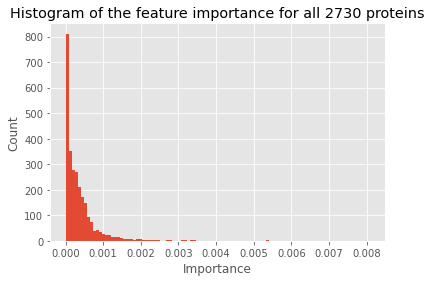

In [18]:
# Feature Selection

"""
Can be used in pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel #checkout description https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

#create Random Forest classifier with default hyperparameters
raFo = RandomForestClassifier()
raFo = raFo.fit(X, y)

#checkout importance in a histogram
plt.hist(raFo.feature_importances_, bins=100)
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")

#get the reduced X
model = SelectFromModel(estimator = raFo, prefit=True)
X_new = model.transform(X)
print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_new.shape}")


In [ ]:
# Feature Selection with SequentialFeatureSelector

"""
Can be used in pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector #checkout description https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

#create Random Forest classifier with default hyperparameters
raFo = RandomForestClassifier()
raFo = raFo.fit(X, y)

#checkout importance in a histogram
plt.hist(raFo.feature_importances_, bins=100)
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")

#get the reduced X
model = SequentialFeatureSelector(estimator = raFo, n_features_to_select = 0.20, cv = 10,  n_jobs=-1)
X_new = model.transform(X)
print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_new.shape}")


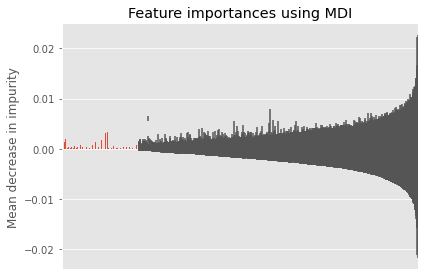

' plt.rcParams["figure.figsize"] = (10,5)\nplt.bar(raFo.feature_names, raFo.feature_importances_)\nplt.xlabel(\'Feature Labels\')\nplt.ylabel(\'Feature Importances\')\nplt.title(\'Comparison of different Feature Importances\'); '

In [45]:
# Visualize feature importance

importances = raFo.feature_importances_

std = np.std([tree.feature_importances_ for tree in raFo.estimators_], axis=0)
std.sort()

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()

""" plt.rcParams["figure.figsize"] = (10,5)
plt.bar(raFo.feature_names, raFo.feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances'); """

## Time to train the model


In [13]:
# import already trained model

clf_RF = joblib.load("rawDataBig/clf_RF_X_new.pkl")
clf_XGRF = joblib.load("rawDataBig/clf_XGRF_X_new.pkl")


/Users/jonathanrieder/opt/anaconda3/envs/becs2/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jonathanrieder/opt/anaconda3/envs/becs2/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Random Forest

In [46]:
#split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=3)

clf_RF = RandomForestClassifier(random_state=1)
clf_RF.fit(X_train ,y_train)
y_RFpred = clf_RF.predict(X_test)




# Model Accuracy, how often is the classifier correct?
print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print(classification_report(y_test, y_RFpred))


Accuracy Random Forest: 0.7333333333333333
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.50      0.80      0.62         5
           2       1.00      0.50      0.67         2
           3       1.00      0.56      0.71         9
           4       1.00      0.71      0.83         7
           5       0.44      0.57      0.50         7
           6       0.90      1.00      0.95         9

    accuracy                           0.73        45
   macro avg       0.79      0.71      0.72        45
weighted avg       0.80      0.73      0.74        45



### XGBoost Random Forest

In [55]:
params = dict(tree_method="exact", 
                eval_metric='mlogloss',
                use_label_encoder =False)

clf_XGRF = xgboost.XGBClassifier(random_state=4, **params)

clf_XGRF.fit(X_train ,y_train)
y_XGRFpred = clf_XGRF.predict(X_test)

print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGRFpred))
print(classification_report(y_test, y_XGRFpred))

Accuracy XGBoost Random Forest: 0.7111111111111111
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.80      0.67         5
           2       0.20      0.50      0.29         2
           3       1.00      0.33      0.50         9
           4       0.88      1.00      0.93         7
           5       1.00      0.71      0.83         7
           6       0.90      1.00      0.95         9

    accuracy                           0.71        45
   macro avg       0.71      0.69      0.66        45
weighted avg       0.80      0.71      0.71        45



In [71]:
#save the model
joblib.dump(clf_RF, "Models/clf_RF_X_new.pkl")
joblib.dump(clf_XGRF, "Models/clf_XGRF_X_new.pkl")

['Models/clf_XGRF_X_new.pkl']

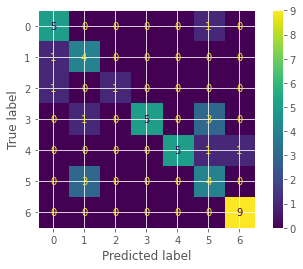

In [52]:
# visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=clf_RF.classes_)
disp.plot(); 



## Compare uncertainty of Data and Model

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_RF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuRF = []
for rs in range(1,6):
    model = RandomForestClassifier(random_state=random.randrange(rs))
    model.fit(X_train, y_train)
    modAcuRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.026
Uncertainty in the model: 0.009
The model performance is 0.618 ± 0.026 ± 0.009


In [56]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_XGRF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()


modAcuXGRF = []
for rs in range(1,6):
    model = xgboost.XGBClassifier(random_state=random.randrange(rs), **params)
    model.fit(X_train, y_train)
    modAcuXGRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuXGRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.074
Uncertainty in the model: 0.000
The model performance is 0.649 ± 0.074 ± 0.000
